In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [25]:
!pip install wordcloud

In [26]:
df= pd.read_csv("spotify_millsongdata.csv")

In [27]:
df.shape

(57650, 4)

In [28]:
df.head()

,artist,song,link,text
0,ABBA,Ahe's My Kind Of Girl,/a/abba/ahes+my+kind+of+girl_20598417.html,"Look at her face, it's a wonderful face \r\nA..."
1,ABBA,"Andante, Andante",/a/abba/andante+andante_20002708.html,"Take it easy with me, please \r\nTouch me gen..."
2,ABBA,As Good As New,/a/abba/as+good+as+new_20003033.html,I'll never know why I had to go \r\nWhy I had...
3,ABBA,Bang,/a/abba/bang_20598415.html,Making somebody happy is a question of give an...
4,ABBA,Bang-A-Boomerang,/a/abba/bang+a+boomerang_20002668.html,Making somebody happy is a question of give an...


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57650 entries, 0 to 57649
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   artist  57650 non-null  object
 1   song    57650 non-null  object
 2   link    57650 non-null  object
 3   text    57650 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB


In [30]:
df.isnull().sum()

artist    0
song      0
link      0
text      0
dtype: int64

In [31]:
# Top artist and songs
top_artists = df['artist'].value_counts().head(10)
print("\nTop 10 Artists:")
print(top_artists)


Top 10 Artists:
Donna Summer        191
Gordon Lightfoot    189
Bob Dylan           188
George Strait       188
Loretta Lynn        187
Cher                187
Alabama             187
Reba Mcentire       187
Chaka Khan          186
Dean Martin         186
Name: artist, dtype: int64


In [32]:
df = df.sample(10000, random_state=42)
df = df.drop('link', axis=1).reset_index(drop=True)

In [33]:
df.shape

(10000, 3)

In [34]:
df.head()

,artist,song,text
0,Wishbone Ash,Right Or Wrong,Like to have you 'round \r\nWith all the lies...
1,Aerosmith,This Little Light Of Mine,"This Little Light of Mine (Light of Mine), \r..."
2,Fall Out Boy,"Dance, Dance",She says she's no good with words but I'm wors...
3,Janis Joplin,Easy Rider,"Hey mama, mama, come a look at sister, \r\nSh..."
4,Moody Blues,Peak Hour,I see it all through my window it seems. \r\n...


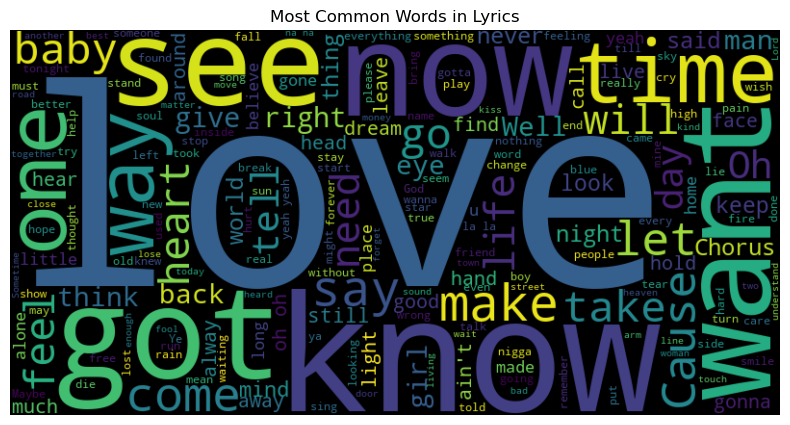

In [35]:
# WordCloud for song lyrics
all_lyrics = " ".join(df['text'].dropna()) 
wordcloud = WordCloud(width=800, height =400, background_color='BLACK').generate(all_lyrics)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most Common Words in Lyrics")  # fixed typo: was `tittle`
plt.show()

In [36]:
# download nltk data
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bidis_lkmqkl9\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\bidis_lkmqkl9\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bidis_lkmqkl9\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [37]:
stop_words = set(stopwords.words('english'))

In [38]:
def preprocess_text(text):
    #Remove special characters and numbers
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    #convert to lower case
    tex = text.lower()
    # Tokenize and remove stopwords
    tokens = word_tokenize(text)
    tokens =[word for word in tokens if word not in stop_words]
    return " ".join(tokens)
#Apply preprocessing to lyrics
df['cleaned_text']= df['text'].apply(preprocess_text)

In [39]:
# Vectorization with Tf-IDF
tfidf_vectorizer = TfidfVectorizer(max_features= 5000)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['cleaned_text'])

In [40]:
# Compute Cosine Similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [41]:
# Recomemendation Function
def recommend_songs(song_name, cosine_sim=cosine_sim, df=df, top_n=5):
    #Find the index of the song
    idx= df[df['song'].str.lower() == song_name.lower()].index
    if len(idx) == 0:
        return "Song not found in the data set!" # can be reworked to compare for songs not present in the dataset
    idx= idx[0]
    
    # Get similarity scores
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    
    #Get song indices
    song_indices = [i[0] for i in sim_scores]
    
    # Return top n similar songs
    return df[['artist', 'song']].iloc[song_indices]

In [42]:
df["song"][2]

'Dance, Dance'

In [43]:
# Example Recomendation
print("\nRecomendations for the song 'You And Me':")
recommendations = recommend_songs("You And Me") 
print(recommendations)


Recomendations for the song 'You And Me':
Song not found in the data set!


In [44]:
import pickle

In [45]:
pickle.dump(recommendations, open("Model_training", "wb"))